### Running a Random Forest Classifier Model.

*RF is robust to unscaled data and reputedly very accurate*

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import re

data1 = pd.read_csv('finaltrain_V2.csv')
data2 = pd.read_csv('finaltest_V2.csv')

In [4]:
data1.shape

(970960, 147)

In [5]:
data2.shape

(907471, 141)

#### From investigation, the additional variables in train data not in test data are:
  list_price_105  
  list_price_126  
  list_price_210  
  plan_days_3  
  plan_days_21  
  list_price_1299  
  list_price_1399 
  
 #### The additional variables in test data not in train data are:
 city_21

In [6]:
# completing dataframes so train and test have the same columns

# test dataframe
data2['list_price_105'] = 0
data2['list_price_126'] = 0
data2['list_price_210'] = 0
data2['plan_days_3'] = 0
data2['plan_days_21'] = 0
data2['list_price_1299'] = 0
data2['list_price_1399'] = 0
# train dataframe
data1['city_21'] = 0

In [7]:
data1.shape

(970960, 148)

In [8]:
data2.shape

(907471, 148)

In [9]:
# creating a function to snakify column names
def snakify(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [10]:
# snakifying column names in both train and test
data1.columns = [snakify(col) for col in data1.columns]
data2.columns = [snakify(col) for col in data2.columns]

In [11]:
# creatiung a list of column names that are def. not dummy variables
subset = list(data1.columns[:17])
type(subset)

list

In [12]:
# looking for the columns that hold null values in both train and hold-out dataset
data1.columns[data1.isnull().any()]

Index(['sum_num_unq', 'avg_num_unq', 'sum_total_number_songs',
       'avg_total_number_songs', 'sum_total_secs', 'avg_total_secs',
       'avg_total_score', 'bd', 'registered_via', 'registration_init_time',
       'registration_init_days', 'total_amount_paid', 'is_auto_renew'],
      dtype='object')

In [13]:
data2.columns[data1.isnull().any()]

Index(['sum_num_unq', 'avg_num_unq', 'sum_total_number_songs',
       'avg_total_number_songs', 'sum_total_secs', 'avg_total_secs',
       'avg_total_score', 'bd', 'registered_via', 'registration_init_time',
       'registration_init_days', 'total_amount_paid', 'is_auto_renew'],
      dtype='object')

In [14]:
# inspecting datatypes in our subset
data1[subset].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 17 columns):
msno                      970960 non-null object
sum_num_unq               754551 non-null float64
avg_num_unq               754551 non-null float64
sum_total_number_songs    754551 non-null float64
avg_total_number_songs    754551 non-null float64
sum_total_secs            754551 non-null float64
avg_total_secs            754551 non-null float64
avg_total_score           754551 non-null float64
bd                        699492 non-null float64
registered_via            699492 non-null float64
registration_init_time    699492 non-null object
registration_init_days    699492 non-null object
no_of_transactions        970960 non-null int64
no_of_cancellations       970960 non-null int64
cancelled                 970960 non-null int64
total_amount_paid         933578 non-null float64
is_auto_renew             933578 non-null float64
dtypes: float64(11), int64(3), object(3)
memory 

In [16]:
# converting the registration date variable from object to float
data1['registration_init_days'] = data1['registration_init_days'].str.replace(" days 00:00:00.000000000","").astype(float)
data2['registration_init_days'] = data2['registration_init_days'].str.replace(" days 00:00:00.000000000","").astype(float)

In [18]:
# subsetting categorical and continuous variables so we can transform with ease
cat = ['registered_via', 'is_auto_renew']
intgr = ['sum_num_unq', 'avg_num_unq', 'sum_total_number_songs', 'avg_total_number_songs', 'sum_total_secs', 'avg_total_secs',
        'avg_total_score', 'bd', 'registration_init_days', 'total_amount_paid']

In [20]:
# how many nulls exist in each of our subsets?
data1[subset].isnull().sum()

msno                           0
sum_num_unq               216409
avg_num_unq               216409
sum_total_number_songs    216409
avg_total_number_songs    216409
sum_total_secs            216409
avg_total_secs            216409
avg_total_score           216409
bd                        271468
registered_via            271468
registration_init_time    271468
registration_init_days    271468
no_of_transactions             0
no_of_cancellations            0
cancelled                      0
total_amount_paid          37382
is_auto_renew              37382
dtype: int64

In [19]:
# from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelEncoder
# from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import Imputer

In [21]:
# we have registration_init_days as a continuous variable so _init_time is excluded
data1 = data1.drop(['registration_init_time'], axis=1)
data2 = data2.drop(['registration_init_time'], axis=1)

In [22]:
# imputing median values to nulls of continuous variables and mode to categoricals
imp_int = Imputer(strategy='median')
imp_cat = Imputer(strategy='most_frequent')

data1[intgr] = imp_int.fit_transform(data1[intgr])
data1[cat] = imp_cat.fit_transform(data1[cat])

In [26]:
data1.head(20)

,msno,sum_num_unq,avg_num_unq,sum_total_number_songs,avg_total_number_songs,sum_total_secs,avg_total_secs,avg_total_score,bd,registered_via,...,city_16,city_17,city_18,city_19,city_20,city_22,is_female,is_male,is_missing,city_21
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,885.0,28.548387,1089.0,35.129032,192527.891052,6210.577131,46.353226,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,468.0,16.714286,567.0,20.250000,115411.258972,4121.830678,35.864643,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,828.0,39.428571,970.0,46.190476,149896.558472,7137.931356,51.978095,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,230.0,7.931034,682.0,23.517241,116433.246857,4014.939547,36.092069,21.0,7.0,...,0,0,1,0,0,0,0,1,0,0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,223.0,10.619048,233.0,11.095238,36636.637947,1744.601807,13.830476,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
5,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,39.0,19.500000,55.0,27.500000,10243.064697,5121.532349,43.285000,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
6,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,115.0,14.375000,157.0,19.625000,28450.267548,3556.283443,28.923750,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
7,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,163.0,18.111111,171.0,19.000000,31788.296082,3532.032898,27.855556,28.0,9.0,...,0,0,0,0,0,0,0,0,1,0
8,++0EzISdtKY48Z0GY62jer/LFQwrNIAbADdtU5xStGY=,186.0,13.285714,319.0,22.785714,65936.727478,4709.766248,39.546429,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
9,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,330.0,19.233333,442.0,25.333333,82640.240601,4709.031179,37.877895,25.0,9.0,...,0,0,0,0,0,0,0,1,0,0


In [27]:
# imputing nulls in test dataset with measures of centrality from train to ensure our final predictions will be accurate
data2[intgr] = imp_int.transform(data2[intgr])
data2[cat] = imp_cat.transform(data2[cat])

In [28]:
data2.head(20)

,msno,sum_num_unq,avg_num_unq,sum_total_number_songs,avg_total_number_songs,sum_total_secs,avg_total_secs,avg_total_score,bd,registered_via,...,is_female,is_male,is_missing,list_price_105,list_price_126,list_price_210,plan_days_3,plan_days_21,list_price_1299,list_price_1399
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,885.0,28.548387,1089.0,35.129032,192527.891052,6210.577131,46.353226,28.0,7.0,...,0,0,1,0,0,0,0,0,0,0
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,828.0,39.428571,970.0,46.190476,149896.558472,7137.931356,51.978095,28.0,7.0,...,0,0,1,0,0,0,0,0,0,0
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,230.0,7.931034,682.0,23.517241,116433.246857,4014.939547,36.092069,21.0,7.0,...,0,1,0,0,0,0,0,0,0,0
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,115.0,14.375000,157.0,19.625000,28450.267548,3556.283443,28.923750,28.0,7.0,...,0,0,1,0,0,0,0,0,0,0
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,163.0,18.111111,171.0,19.000000,31788.296082,3532.032898,27.855556,28.0,9.0,...,0,0,1,0,0,0,0,0,0,0
5,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,330.0,19.233333,442.0,25.333333,82640.240601,4709.031179,37.877895,25.0,9.0,...,0,1,0,0,0,0,0,0,0,0
6,++0wqjjQge1mBBe5r4ciHGKwtF/m322zkra7CK8I+Mw=,330.0,19.233333,442.0,25.333333,82640.240601,4709.031179,37.877895,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
7,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,490.0,35.000000,693.0,49.500000,161863.900574,11561.707184,92.057858,28.0,7.0,...,0,0,1,0,0,0,0,0,0,0
8,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,127.0,21.166667,300.0,50.000000,78837.018616,13139.503103,91.276665,28.0,7.0,...,0,0,1,0,0,0,0,0,0,0
9,++1Wu2wKBA60W9F9sMh15RXmh1wN1fjoVGzNqvw/Gro=,330.0,19.233333,442.0,25.333333,82640.240601,4709.031179,37.877895,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Investigating the distribution of churn levels
data1['is_churn'].value_counts()

0    883630
1     87330
Name: is_churn, dtype: int64

In [30]:
X, y = data1.drop(['is_churn', 'msno'], axis=1), data1['is_churn']

# ensuring we create an even split of the dependent variable (churn)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=13)
for train_index, test_index in sss.split(X, y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    # reserving some train data to test our random forest best estimator prior to feeding new data
    X_test, y_test = X.loc[test_index], y.loc[test_index]

In [34]:
# searching for best combination of parameters
rf_grid = [{'n_estimators':range(20,35,5),'random_state':[5,13],'criterion':['gini','entropy']}]

rf = RandomForestClassifier(verbose=2, n_jobs=2, warm_start=True)
gridsearchRF = GridSearchCV(rf, rf_grid, cv=8)
gridsearchRF.fit(X_train, y_train)

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   42.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.6s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   49.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.5s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   42.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.0s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   55.6s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.7s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   43.6s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   43.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.5s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   42.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   44.5s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   39.8s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.5s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   41.0s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   39.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   39.0s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.6s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   39.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   43.8s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   52.0s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   51.7s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.1s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.7s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.2s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.1s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   47.9s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.7s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   49.0s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   47.7s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   57.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.9s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.1s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   51.4s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.1s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   55.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   51.2s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.6s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.1s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.8s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.6s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   59.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.4s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.7s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.5s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   59.2s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.5s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   59.3s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.5s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.7s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.7s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    4.0s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.6s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.9s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    4.0s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    4.0s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30building tree 22 of 30

building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    4.2s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    4.1s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    4.9s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   42.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   41.8s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   41.0s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   43.5s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.4s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   39.7s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.5s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.0s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.8s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   39.5s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   43.1s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   39.9s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.6s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.8s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   51.6s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.8s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.8s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.2s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   51.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.0s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.8s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   49.2s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.8s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   53.0s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.3s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   50.7s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25building tree 8 of 25

building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   51.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   51.8s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   52.0s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   52.5s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.1s finished


building tree 1 of 25
building tree 2 of 25
building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   51.4s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.1s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   52.9s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    2.9s finished


building tree 1 of 25building tree 2 of 25

building tree 3 of 25
building tree 4 of 25
building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:   52.0s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    3.3s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.7s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.6s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.4s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.3s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.6s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30building tree 10 of 30

building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.5s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.5s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.6s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.5s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.5s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.6s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.3s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.4s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.7s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.6s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.6s finished


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.2min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=2, warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': range(20, 35, 5), 'random_state': [5, 13], 'criterion': ['gini', 'entropy']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
gridsearchRF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=2, oob_score=False, random_state=13,
            verbose=2, warm_start=True)

**Reducing verbosity in subsequent grid searches to keep notebook simple since we now know what's happening under the hood.**

In [38]:
# adding more trees to the grid search (max of 200 trees) to make model more accurate.
rf_grid = [{'n_estimators':range(100,210,10)}]

rf = RandomForestClassifier(warm_start=True, random_state=13, criterion='gini')
gridsearchRF = GridSearchCV(rf, rf_grid, cv=8)
gridsearchRF.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=13,
            verbose=0, warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': range(100, 210, 10)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
# The best estimator uses 170 trees
gridsearchRF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=170, n_jobs=1, oob_score=False, random_state=13,
            verbose=0, warm_start=True)

In [40]:
# assigning best estimator to a variable
rf_best = gridsearchRF.best_estimator_

In [43]:
# viewing feature importance
for score, feature in sorted(zip(rf_best.feature_importances_,data1.columns),reverse=True):
    print(score, feature)

0.212013073565 plan_days_7
0.101750463317 cancelled
0.0627505449814 no_of_transactions
0.0541710169671 no_of_cancellations
0.0447919574067 registered_via
0.0390091411712 registration_init_days
0.0370489669166 avg_total_number_songs
0.0352671609967 avg_num_unq
0.0350923190878 msno
0.0336231015468 sum_total_secs
0.0335141163157 avg_total_secs
0.0321180727834 sum_total_number_songs
0.0317322989613 sum_num_unq
0.0288085861136 list_price_129
0.021899607874 is_female
0.018831701651 payment_method_40
0.0156285607885 payment_method_31
0.015346516483 total_amount_paid
0.0149148428796 list_price_1399
0.0148269350387 avg_total_score
0.0102293000606 bd
0.00966549408286 list_price_0
0.00915972589052 payment_method_38
0.00809543089426 city_20
0.00775534111073 list_price_150
0.0073116774963 city_22
0.00642303679637 list_price_894
0.00480595491428 payment_method_35
0.00454080418983 plan_days_195
0.00425456474315 plan_days_31
0.00296232723622 list_price_536
0.00295809408058 plan_days_120
0.002935641191

In [44]:
# extracting the prediction probabilities
y_rf = rf_best.predict(X_test)
y_rfproba = rf_best.predict_proba(X_test)

# inspecting for misclassifications
confusion_matrix(y_test, y_rf)

array([[174854,   1872],
       [  3451,  14015]])

**2.74% misclassified.**

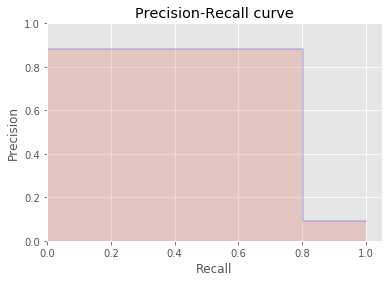

In [71]:
precision, recall, thresholds = precision_recall_curve(y_test, y_rf)

plt.step(recall, precision, alpha=0.2, where='post', color='b')
plt.fill_between(recall, precision, step='post', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.05])
plt.title('Precision-Recall curve')

**We can at least confirm we have avoided overfitting**

In [59]:
f1_score(y_test, y_rf)

0.84040416154468855

In [54]:
# running our estimator on new data
X_new = data2.drop(['is_churn', 'msno'], axis=1)
y_proba = rf_best.predict_proba(X_new)

# appending the probabilities to the test dataframe
rf_ans = data2[['msno', 'bd']]
rf_ans['is_churn'] = y_proba[:, 1]
rf_ans = rf_ans.drop(['bd'], axis=1)

C:\Users\Laolu\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
# the submission contains the probabilities of churn as opposed to whether churn or no churn
rf_ans.head(10)

,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.011765
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.017647
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.005882
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.052941
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.182353
5,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0.002914
6,++0wqjjQge1mBBe5r4ciHGKwtF/m322zkra7CK8I+Mw=,0.000082
7,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,0.047059
8,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,0.023529
9,++1Wu2wKBA60W9F9sMh15RXmh1wN1fjoVGzNqvw/Gro=,0.000082


In [57]:
rf_ans.to_csv('submission1_v2.csv', index=False)

** This submission puts us at 145th out of 350 with a logloss of 0.15552. **